# Analysis of SARS-CoV-2 cytopathic effect (CPE)  qHTS data

#### This notebooks details the analysis of SARS-CoV-2 cytopathic effect (CPE) screening data from NCATS

Outcomes: True actives w/ antiviral activity protect the host from the virus, but not kill the host cell in counterscreens

Primary Assay Data: https://opendata.ncats.nih.gov/covid19/assay?aid=14

Counter Screen Data: https://opendata.ncats.nih.gov/covid19/assay?aid=15

#### If using the data from this notebook, please cite: https://www.biorxiv.org/content/10.1101/2020.06.04.135046v1

#### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [20:17:36] Enabling RDKit 2019.09.3 jupyter extensions


### In the first section of the notebook we will curate the primary HTS data

#### Read the file containing the primary screening data 

In [2]:
file = 'SARS-CoV-2_cytopathic_effect_(CPE).tsv'

In [3]:
primary = pd.read_csv(file, sep='\t')  

In [4]:
print('Uncurated primary qHTS data: ', primary.shape)
primary.head()

Uncurated primary qHTS data:  (7215, 53)


,SAMPLE_ID,SAMPLE_NAME,PUBCHEM_SID,PRIMARY_MOA,ASSAY_NAME,LIBRARY,CAS,ALIAS,AC50,LOG_AC50,...,CONC5,CONC6,CONC7,CONC8,CONC9,CONC10,CONC11,CONC12,CONC13,CONC14
0,NCGC00181349-02,Ranelic acid distrontium salt,225144325.0,Calcium-Sensing Receptor (CaSR) Agonist,DPI_SARS-CoV-2_General,2019_NPC-4_CPE,135459-87-9,Strontium Ranelate;3-(3-cyano-4-carboxymethyl-...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCGC00018193-11,Fluvoxamine,170464809.0,5-HT Reuptake Inhibitor,DPI_SARS-CoV-2_General,2019_NPC-4_CPE,54739-18-3,;FLUVOXAMINE MALEATE;Fluvoxamine; Fluvoxamina;...,12.589254,-4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCGC00091070-02,Diisopropylamine,170466002.0,Pyruvate dehydrogenase kinase isoform 4 Inhibitor,DPI_SARS-CoV-2_General,2019_NPC-4_CPE,108-18-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCGC00263541-01,Reboxetine mesylate,170465620.0,NaN,SARS-CoV-2_CPE_SRI,2019_NPC-2.2,98769-84-7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCGC00160421-03,Tetrabenazine,170464675.0,Vesicular Monoamine Transporter 2 (VMAT2) Inhi...,SARS-CoV-2_CPE_SRI,2019_NPC-3.2,58-46-8,; Nitoman;Tetrabenazine; Tetrabenazine; Tetra...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the dataframe

In [5]:
#Inspect the columns and decide which we need which we can drop
primary.columns

Index(['SAMPLE_ID', 'SAMPLE_NAME', 'PUBCHEM_SID', 'PRIMARY_MOA', 'ASSAY_NAME',
       'LIBRARY', 'CAS', 'ALIAS', 'AC50', 'LOG_AC50', 'AUC', 'CURVE_CLASS2',
       'DATA_POINTS', 'DRUG_NAME', 'EFFICACY', 'MAX_RESPONSE', 'P_HILL', 'R2',
       'GENE_ID', 'GENE_SYMBOL', 'SMILES', 'SUPPLIER', 'SUPPLIER_ID', 'DATA0',
       'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'DATA8',
       'DATA9', 'DATA10', 'DATA11', 'DATA12', 'DATA13', 'DATA14', 'CONC0',
       'CONC1', 'CONC2', 'CONC3', 'CONC4', 'CONC5', 'CONC6', 'CONC7', 'CONC8',
       'CONC9', 'CONC10', 'CONC11', 'CONC12', 'CONC13', 'CONC14'],
      dtype='object')

#### we will want to keep compound identifiers, smiles, curve classes, and log_AC50 
note: most of our activity curation will come from curve class curation and not any activity endpoints directly.

In [6]:
#make a list of columns to drop and then drop. 

drop_columns = ['PUBCHEM_SID', 'PRIMARY_MOA', 'ASSAY_NAME','LIBRARY', 'CAS', 'ALIAS', 'AC50','AUC','DATA_POINTS', 'DRUG_NAME', 'EFFICACY', 'MAX_RESPONSE', 'P_HILL', 'R2', 'GENE_ID', 'GENE_SYMBOL','SUPPLIER', 'SUPPLIER_ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'DATA8', 'DATA9', 'DATA10', 'DATA11', 'DATA12', 'DATA13', 'DATA14', 'CONC0','CONC1', 'CONC2', 'CONC3', 'CONC4', 'CONC5', 'CONC6', 'CONC7', 'CONC8','CONC9', 'CONC10', 'CONC11', 'CONC12', 'CONC13', 'CONC14']

df = primary.drop(drop_columns, axis=1)

print('Cleaned Up Dataset:')
df.head(1)

Cleaned Up Dataset:


,SAMPLE_ID,SAMPLE_NAME,LOG_AC50,CURVE_CLASS2,SMILES
0,NCGC00181349-02,Ranelic acid distrontium salt,NaN,4.0,O.O.O.O.O.O.O.[Sr++].[Sr++].[O-]C(=O)CN(CC([O-...


#### More clean up: add a pAC50 measure, visualize compounds, and reorder the columns

,Mol,SAMPLE_ID,SAMPLE_NAME,pAC50,CURVE_CLASS2,SMILES
0,,NCGC00181349-02,Ranelic acid distrontium salt,NaN,4.0,O.O.O.O.O.O.O.[Sr++].[Sr++].[O-]C(=O)CN(CC([O-...
1,,NCGC00018193-11,Fluvoxamine,4.9,4.0,FC(F)(F)c1ccc(cc1)C(\CCCCOC)=N\OCCN
2,,NCGC00091070-02,Diisopropylamine,NaN,4.0,CC(C)NC(C)C
3,,NCGC00263541-01,Reboxetine mesylate,NaN,4.0,CS(=O)(=O)O.CCOc3ccccc3O[C@H](c1ccccc1)[C@H]2C...
4,,NCGC00160421-03,Tetrabenazine,NaN,4.0,CC(C)CC2CN3CCc1cc(OC)c(OC)cc1C3CC2=O

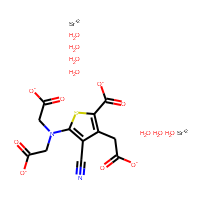
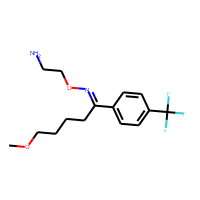
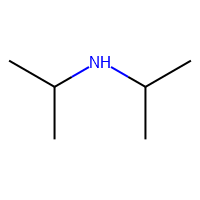
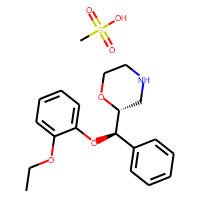
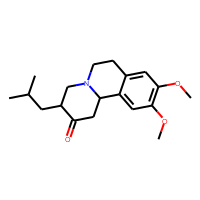

In [7]:
df['pAC50'] = df.LOG_AC50*-1
df.drop('LOG_AC50', axis=1, inplace=True)

PandasTools.AddMoleculeColumnToFrame(df,"SMILES","Mol")

cols = ['Mol','SAMPLE_ID','SAMPLE_NAME','pAC50','CURVE_CLASS2','SMILES']
df = df[cols]

df.head()

#### Curve Classes give us a better sense of the quality of the activity than the pAC50 alone.
#### We are interested in specific curve classes that are associated with "good curves", which will be a proxy for meaningful activity
Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1518803/

In [8]:
#Inspect the distrubution of curve classes
df.groupby(['CURVE_CLASS2']).size()

CURVE_CLASS2
-1.2       1
 1.1      21
 1.2      18
 1.3       8
 1.4      28
 2.1      14
 2.2      27
 2.3       8
 2.4      66
 3.0     481
 4.0    6533
 5.0      10
dtype: int64

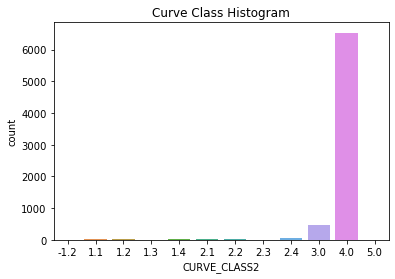

In [9]:
#Plot it out
ax = plt.subplots()
ax = sns.countplot(df['CURVE_CLASS2'], data=df)
ax.set_title('Curve Class Histogram')
plt.show()

### antiviral compounds increase cell viability. So we want positive curves. 4.0 is inactive.
We have mostly inactive compounds with just a smattering of active compounds with good dose-response curves.

As always we need to ask, what is the reproducibility? and how many of these actives are *true* actives?

#### We will categorize inactive curves as 0, acceptable curves as 1, and ambiguous curves as 999

In [10]:
#inactive
df.loc[(df['CURVE_CLASS2'] == 4.0), 'activity'] = 0

#active
df.loc[(df['CURVE_CLASS2'] == 1.1), 'activity'] = 1
df.loc[(df['CURVE_CLASS2'] == 1.2), 'activity'] = 1
df.loc[(df['CURVE_CLASS2'] == 2.1), 'activity'] = 1
df.loc[(df['CURVE_CLASS2'] == 2.2), 'activity'] = 1

#ambiguous
df.loc[(df['CURVE_CLASS2'] != 4) & (df['CURVE_CLASS2'] != 1.1) & (df['CURVE_CLASS2'] != 1.2) & (df['CURVE_CLASS2'] != 2.1) & (df['CURVE_CLASS2'] != 2.2), 'activity'] = 999

,Mol,SAMPLE_ID,SAMPLE_NAME,pAC50,CURVE_CLASS2,SMILES,activity
0,,NCGC00181349-02,Ranelic acid distrontium salt,NaN,4.0,O.O.O.O.O.O.O.[Sr++].[Sr++].[O-]C(=O)CN(CC([O-...,0

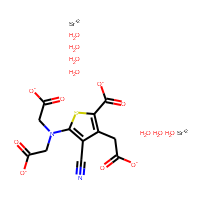

In [11]:
#recast our new column as an int and inspect
df['activity'] = df['activity'].astype('int') 
df.head(1)

#### Curate replicates
Replicates may come from the same SAMPLE_ID, SAMPLE_NAME, or have the same SMILES

In [12]:
#Inspect how many compounds have replicate SAMPLE_ID

sample_id_dups = df.groupby('SAMPLE_ID').filter(lambda x: x['SAMPLE_ID'].count() > 1)
print('Number of replicate compounds:')
print(sample_id_dups.shape)

Number of replicate compounds:
(2533, 7)


In [13]:
#Inspect how of those replicate compounds have inconsistent activity readouts

sample_id_dups_filtered = sample_id_dups.groupby('SAMPLE_ID').filter(lambda x: x['activity'].nunique() > 1)
print('Number of replicate compounds with inconsistent activity:')
print(sample_id_dups_filtered.shape)

Number of replicate compounds with inconsistent activity:
(179, 7)


In [14]:
#ensures inconsistent replicates are not in df
df = df[~df['SAMPLE_ID'].isin(sample_id_dups_filtered.SAMPLE_ID)]

#keeps one unique compound if the replicate is reproducible
df.drop_duplicates("SAMPLE_ID",inplace=True)

print('Partially curated dataset:')
print(df.shape)

Partially curated dataset:
(5815, 7)


In [15]:
#Repeat analysis for SAMPLE_NAME and SMILES

In [16]:
sample_name_dups = df.groupby('SAMPLE_NAME').filter(lambda x: x['SAMPLE_NAME'].count() > 1)
print('Number of replicate compounds:')
print(sample_name_dups.shape)

Number of replicate compounds:
(272, 7)


In [17]:
sample_names_dups_filtered = sample_name_dups.groupby('SAMPLE_NAME').filter(lambda x: x['activity'].nunique() > 1)
print('Number of replicate compounds with inconsistent activity:')
print(sample_names_dups_filtered.shape)

Number of replicate compounds with inconsistent activity:
(18, 7)


In [18]:
#ensures keys from df_2.SAMPLE_ID are not in df
df = df[~df['SAMPLE_NAME'].isin(sample_names_dups_filtered.SAMPLE_NAME)]
df.drop_duplicates("SAMPLE_NAME",inplace=True)
print('Partially curated dataset:')
print(df.shape)

Partially curated dataset:
(5670, 7)


In [19]:
smiles_dups = df.groupby('SMILES').filter(lambda x: x['SMILES'].count() > 1)
print('Number of replicate compounds:')
print(sample_name_dups.shape)

Number of replicate compounds:
(272, 7)


In [20]:
smiles_dups_filtered = sample_name_dups.groupby('SMILES').filter(lambda x: x['activity'].nunique() > 1)
print('Number of replicate compounds with inconsistent activity:')
print(sample_names_dups_filtered.shape)

Number of replicate compounds with inconsistent activity:
(18, 7)


In [21]:
#ensures keys from df_2.SAMPLE_ID are not in df
df = df[~df['SMILES'].isin(smiles_dups_filtered.SMILES)]


df.drop_duplicates("SMILES",inplace=True)

print('Partially curated dataset:')
print(df.shape)

Partially curated dataset:
(5363, 7)


In [22]:
#Remove any remaining inconclusive classes and the positive control Biotin

df = df[df.activity != 999]
df = df[df.SAMPLE_NAME != "Biotin"]

print('Partially curated dataset:')
print(df.shape)

Partially curated dataset:
(4937, 7)


#### Inspect the curated dataset for the primary HTS

In [23]:
df_actives = df[df.activity == 1]
print('Actives in the primary screen:')
print(df_actives.shape)

#write out if needed
#df_actives.to_csv('actives.csv')

Actives in the primary screen:
(31, 7)


In [24]:
df_inactive = df[~df['SAMPLE_ID'].isin(df_actives.SAMPLE_ID)]
print('Inactives in the primary screen:')
print(df_inactive.shape)

#write out if needed
#df_inactives.to_csv('inactives.csv')

Inactives in the primary screen:
(4906, 7)


### In the second section of the notebook we will further curate the primary HTS data based on the counterscreen

#### read the file

In [25]:
file2 = 'SARS-CoV-2_cytopathic_effect_(host_tox_counterscreen).tsv'

In [26]:
counter = pd.read_csv(file2, sep='\t')  
print('Uncurated dataset:')
print(counter.shape)

Uncurated dataset:
(6160, 53)


In [27]:
#Inspect the distrubution of curve classes
counter.groupby(['CURVE_CLASS2']).size()

CURVE_CLASS2
-3.0     498
-2.4     141
-2.3      82
-2.2     103
-2.1     163
-1.4      52
-1.3      63
-1.2      47
-1.1     111
 4.0    4828
 5.0      72
dtype: int64

As we can see, we have lots of negative curve classes. That means inhibition. Our host is being killed by our compounds!
We want compounds that kill the virus (primary screen) but don't kill the host in the process!

#### Define a function to categorize the counter screen outcome
A true active will be active in the primary but inactive in the counterscreen. We want to ensure our compound is not killing the virus AND killing the host!

In [28]:
def curate(df_in):
    
    df_in.loc[(df_in['CURVE_CLASS2'] == 4.0), 'activity'] = 0   
    df_in.loc[(df_in['CURVE_CLASS2'] != 4.0), 'activity'] = 1   
    df_in['activity'] = df_in['activity'].astype('int') 
    df_out = df_in[df_in.activity == 1]
    return df_out

In [29]:
df_counter = curate(counter)
print(df_counter.shape)
df_counter.head(2)

(1332, 54)


,SAMPLE_ID,SAMPLE_NAME,PUBCHEM_SID,PRIMARY_MOA,ASSAY_NAME,LIBRARY,CAS,ALIAS,AC50,LOG_AC50,...,CONC6,CONC7,CONC8,CONC9,CONC10,CONC11,CONC12,CONC13,CONC14,activity
14,NCGC00023509-13,Lovastatin,170464913.0,HMG-CoA Reductase Inhibitor,DPI_SARS-CoV-2_General,2019_NPC-4_Tox,75330-75-5,; ; Lovastatin (Mevinolin); Monacolin K; Mevac...,7.943282,-5.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
26,NCGC00159476-09,Tribromsalan,170465542.0,NaN,DPI_SARS-CoV-2_General,2019_NPC-1_Tox,87-10-5,NaN,4.466836,-5.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


remove any nonspecific actives from our primary active df

In [30]:
true = df_actives[~df_actives['SAMPLE_ID'].isin(df_counter.SAMPLE_ID)]
print('True actives in the primary screen:')
print(true.shape)

True actives in the primary screen:
(16, 7)


,Mol,SAMPLE_ID,SAMPLE_NAME,pAC50,CURVE_CLASS2,SMILES,activity
6136,,NCGC00509936-02,NCGC00509936-02,5.0,2.2,C[N]1C=C(C=N1)C2=CC=C(C=C2)C3=CN=CC(=C3N4CCC5(...,1
6669,,NCGC00242493-09,NCGC00242493-09,5.6,1.2,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=C[N]...,1
6760,,NCGC00346625-03,NCGC00346625-03,5.2,2.2,FC1=CC=C(C=C1)C2=CC=C(O2)\C=C/3SC(=O)NC3=O,1
7049,,NCGC00345807-02,NCGC00345807-02,6.5,1.1,OC1=CC=C(CCNC(=O)[C@H]2O[C@@H]2C(=O)N[C@@H](CC...,1
7142,,NCGC00345806-02,NCGC00345806-02,5.0,2.1,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)OCC...,1

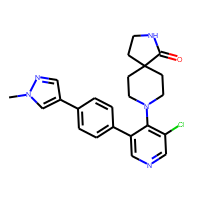
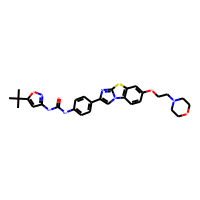
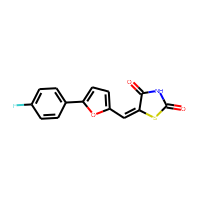
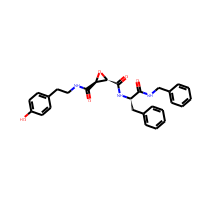
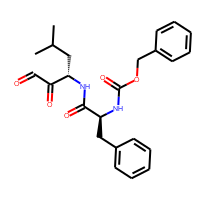

In [31]:
true.tail()

### Write out the file

In [32]:
#true.to_csv('true_positives_cpe.csv');